--------------
**Validation of Bitcoin Addresses and Illicit Class Status**

Key insights so far:
- Address datasets with duplicates have been de-duplicated, removing noise in the datasets.
- Address and transaction datasets have been enhanced by adding class labels to the dataset.
- Enhanced tables are created which end in '_clean'.

Purpose of this notebook:
- The purpose of this notebook is to spot check illicit addresses using external third party blockchain websites to validate the address is legitimate and the transactions in the dataset align with the public blockchain data.
- Validation includes checking the address is legitimiate, the transaction data matches public blockchain data and sending, receiving addresses and bitcoin transaction details match.
- Validation of illicit status where the third party blockchain website includes flagging of scam, money laundering or other illicit behaviour.
- The original Elliptic dataset cannot be used because the addresses and transaction IDs are masked, and cannot be validated as a result.

Measure of success:
- Validate 10 randomly selected addresses from the dataset using public blockchain website, BTC Scan, to confirm the transaction data is correct and can be relied on for analysis.
- Validate the status of the illicit flag created in the original Elliptic/IBM dataset.

Outcome:
- 10 illicit address samples from the Elliptic++ dataset have been successfully validated using BTC Scan. This means that the addresses are legitimate, the sending and receiving accounts are legitimate and the transaction details are correct. This means the dataset is reliable and can be used for future analysis.
- As a result of the addresses and transactions being validated using BTC scan, the Elliptic++ dataset is reliable and can be used for future analysis.
- The 'illicit' label could not be validated using free blockchain scam websites Cybertrace and Chainabuse. There may be blockchain illicit websites that detect an illicit label but these are behind a paywall.

--------------

The Elliptic++ dataset is an enhancement of the Elliptic1 dataset. This dataset includes transaction information that can be validated using blockchain wallet search websites. See here:

Elliptic1 Paper and Dataset:
https://arxiv.org/pdf/1908.02591
https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data

Elliptic++ Paper and Dataset:
https://arxiv.org/pdf/2306.06108
https://github.com/git-disl/EllipticPlusPlus

--------------

In [1]:
# Data cleaning and manipulation
import pandas as pd
import numpy as np
from pandas_gbq import to_gbq

# Set up display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


-------------------

Read in Datasets used for Validation

-------------------

Dataset 1: Aggregate 'wallets_combined_clean' dataset which contains aggregate transaction information at an address level and contains the class (illicit, licit or unknown).

Dataset 2: The 'addraddr_edgelist' which contains a directional address to address (sending address to receiving address) which will be used to validate the addresses involved in the transaction.

Dataset 3: The 'addrtxn_edgelist' will be used to look up the masked transaction ID to find the transaction features in 'txn_features' table.

Dataset 4: The 'txn_features' dataset contains both masked and unmasked transaction features that will be used to validate the 30 samples.

In [2]:
# Read in combined wallet features table from BigQuery
%%bigquery df_wallet_combined_clean
select * from `extreme-torch-467913-m6.actor.wallets_combined_clean`;

Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
print(df_wallet_combined_clean.shape)
df_wallet_combined_clean.head(1)

(822942, 58)


address  class class_label  num_txs_as_sender  \
0  12J3Zh4oBkttwRSXaTu3Gavr71J8K9Nw1v      3     Unknown             1.0000   

   num_txs_as receiver  first_block_appeared_in  last_block_appeared_in  \
0               0.0000              465796.0000             465796.0000   

   lifetime_in_blocks  total_txs  first_sent_block  first_received_block  \
0              0.0000     1.0000       465796.0000                0.0000   

   num_timesteps_appeared_in  btc_transacted_total  btc_transacted_min  \
0                     1.0000                0.0174              0.0174   

   btc_transacted_max  btc_transacted_mean  btc_transacted_median  \
0              0.0174               0.0174                 0.0174   

   btc_sent_total  btc_sent_min  btc_sent_max  btc_sent_mean  btc_sent_median  \
0          0.0174        0.0174        0.0174         0.0174           0.0174   

   btc_received_total  btc_received_min  btc_received_max  btc_received_mean  \
0              0.0000            0.0000            0.0000             0.0000   

   btc_received_median  fees_total  fees_min  fees_max  fees_mean  \
0               0.0000      0.0105    0.0105    0.0105     0.0105   

   fees_median  fees_as_share_total  fees_as_share_min  fees_as_share_max  \
0       0.0105               0.0003             0.0003             0.0003   

   fees_as_share_mean  fees_as_share_median  blocks_btwn_txs_total  \
0              0.0003                0.0003                 0.0000   

   blocks_btwn_txs_min  blocks_btwn_txs_max  blocks_btwn_txs_mean  \
0               0.0000               0.0000                0.0000   

   blocks_btwn_txs_median  blocks_btwn_input_txs_total  \
0                  0.0000                       0.0000   

   blocks_btwn_input_txs_min  blocks_btwn_input_txs_max  \
0                     0.0000                     0.0000   

   blocks_btwn_input_txs_mean  blocks_btwn_input_txs_median  \
0                      0.0000                        0.0000   

   blocks_btwn_output_txs_total  blocks_btwn_output_txs_min  \
0                        0.0000                      0.0000   

   blocks_btwn_output_txs_max  blocks_btwn_output_txs_mean  \
0                      0.0000                       0.0000   

   blocks_btwn_output_txs_median  num_addr_transacted_multiple  \
0                         0.0000                        0.0000   

   transacted_w_address_total  transacted_w_address_min  \
0                      2.0000                    1.0000   

   transacted_w_address_max  transacted_w_address_mean  \
0                    1.0000                     1.0000   

   transacted_w_address_median  
0                       1.0000

In [4]:
# Read in address to address table from BigQuery
%%bigquery df_addraddr
select * from `extreme-torch-467913-m6.actor.addraddr_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [5]:
print(df_addraddr.shape)
df_addraddr.head(1)

(2868964, 2)


input_address                      output_address
0  3NxNuqV5LUJRYdLB5HZFb7iS38XYKhfzEj  3EoPc6HG8Qsiuam6vUE3BUYXNoNDTALcAN

In [6]:
# Read in address to transaction table from BigQuery
%%bigquery df_addrtxn_edgelist
select * from `extreme-torch-467913-m6.actor.addrtxn_edgelist`;

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
print(df_addrtxn_edgelist.shape)
df_addrtxn_edgelist.head(1)

(477117, 2)


input_address       txId
0  14YRXHHof4BY1TVxN5FqYPcEdpmXiYT78a  230325127

In [8]:
# Read in address to address table from BigQuery
%%bigquery df_txn_features
select * from `extreme-torch-467913-m6.txn.txn_features`;

Query is running:   0%|          |

Downloading:   0%|          |

In [9]:
# subset txn feature to remove all masked aggregate and local features

# Remove columns containing 'Aggregate_feature_' or 'Local_feature_'
columns_to_remove = [col for col in df_txn_features.columns if 'Aggregate_feature_' in col or 'Local_feature_' in col]
df_txn_features = df_txn_features.drop(columns=columns_to_remove)

In [10]:
print(df_txn_features.shape)
df_txn_features.head(1)

(203769, 19)


txId  Time step  in_txs_degree  out_txs_degree  total_BTC  fees  size  \
0  30549576          8            NaN             NaN        NaN   NaN   NaN   

   num_input_addresses  num_output_addresses  in_BTC_min  in_BTC_max  \
0                  NaN                   NaN         NaN         NaN   

   in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  out_BTC_max  \
0          NaN            NaN           NaN          NaN          NaN   

   out_BTC_mean  out_BTC_median  out_BTC_total  
0           NaN             NaN            NaN

----------------------

Illicit Samples where the volume of transactions is low.

The reason for selecting addresses with low transaction values is so we can validate the transactions using third party Blockchain websites.

----------------------

In [11]:
illicit_samples = df_wallet_combined_clean[(df_wallet_combined_clean['class_label']=='Illicit') & (df_wallet_combined_clean['num_txs_as_sender']==1) & (df_wallet_combined_clean['total_txs']==1)].sort_values(ascending = True, by = 'total_txs').head(10)
illicit_samples

address  class class_label  \
180915  161wGjTCaepqFjMeVfYaQxSnDR4Qurj1Xf      1     Illicit   
180712  1LxV1rfMizNv5qZiTvkBiLdCHwdhBzYYJW      1     Illicit   
180709  14tVmRUdudeviCqemDSKtrpBKZdDoaydSN      1     Illicit   
180487  199NKVNmVhAf4uur2zaJzqhh4Q1g78gFFx      1     Illicit   
180475  1PWZxVszPvtaJkWTTuBBgMLJbAMGQQhB8Z      1     Illicit   
180452  1JHLEhok9W44B2Bt8ZAmC5R18FnVYmFZoD      1     Illicit   
180364  1Gn2zJUYH8v3Vzbx2hjmF9yhAVqCo3rByS      1     Illicit   
180278  1MMd9KsaDHHG5tYi6bHqbsxqzFnKKxaPB2      1     Illicit   
180211  14HJqsSLCX4ZoQ8qzTVRidMirrUK94XNYt      1     Illicit   
180096  18e1LywPqM782xcrf3fJcGkhBZmTE17pbu      1     Illicit   

        num_txs_as_sender  num_txs_as receiver  first_block_appeared_in  \
180915             1.0000               0.0000              481927.0000   
180712             1.0000               0.0000              441601.0000   
180709             1.0000               0.0000              477888.0000   
180487             1.0000               0.0000              403301.0000   
180475             1.0000               0.0000              441601.0000   
180452             1.0000               0.0000              407339.0000   
180364             1.0000               0.0000              431522.0000   
180278             1.0000               0.0000              485958.0000   
180211             1.0000               0.0000              481927.0000   
180096             1.0000               0.0000              487969.0000   

        last_block_appeared_in  lifetime_in_blocks  total_txs  \
180915             481927.0000              0.0000     1.0000   
180712             441601.0000              0.0000     1.0000   
180709             477888.0000              0.0000     1.0000   
180487             403301.0000              0.0000     1.0000   
180475             441601.0000              0.0000     1.0000   
180452             407339.0000              0.0000     1.0000   
180364             431522.0000              0.0000     1.0000   
180278             485958.0000              0.0000     1.0000   
180211             481927.0000              0.0000     1.0000   
180096             487969.0000              0.0000     1.0000   

        first_sent_block  first_received_block  num_timesteps_appeared_in  \
180915       481927.0000                0.0000                     1.0000   
180712       441601.0000                0.0000                     1.0000   
180709       477888.0000                0.0000                     1.0000   
180487       403301.0000                0.0000                     1.0000   
180475       441601.0000                0.0000                     1.0000   
180452       407339.0000                0.0000                     1.0000   
180364       431522.0000                0.0000                     1.0000   
180278       485958.0000                0.0000                     1.0000   
180211       481927.0000                0.0000                     1.0000   
180096       487969.0000                0.0000                     1.0000   

        btc_transacted_total  btc_transacted_min  btc_transacted_max  \
180915                0.0066              0.0066              0.0066   
180712                0.0157              0.0157              0.0157   
180709                2.7573              2.7573              2.7573   
180487                0.0116              0.0116              0.0116   
180475                0.0066              0.0066              0.0066   
180452                0.0403              0.0403              0.0403   
180364                0.0083              0.0083              0.0083   
180278                0.0090              0.0090              0.0090   
180211                0.0024              0.0024              0.0024   
180096                0.0130              0.0130              0.0130   

        btc_transacted_mean  btc_transacted_median  btc_sent_total  \
180915               0.0066                 0.0066          0.0066

-----------------------

Illicit Address Validation #1: 1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------

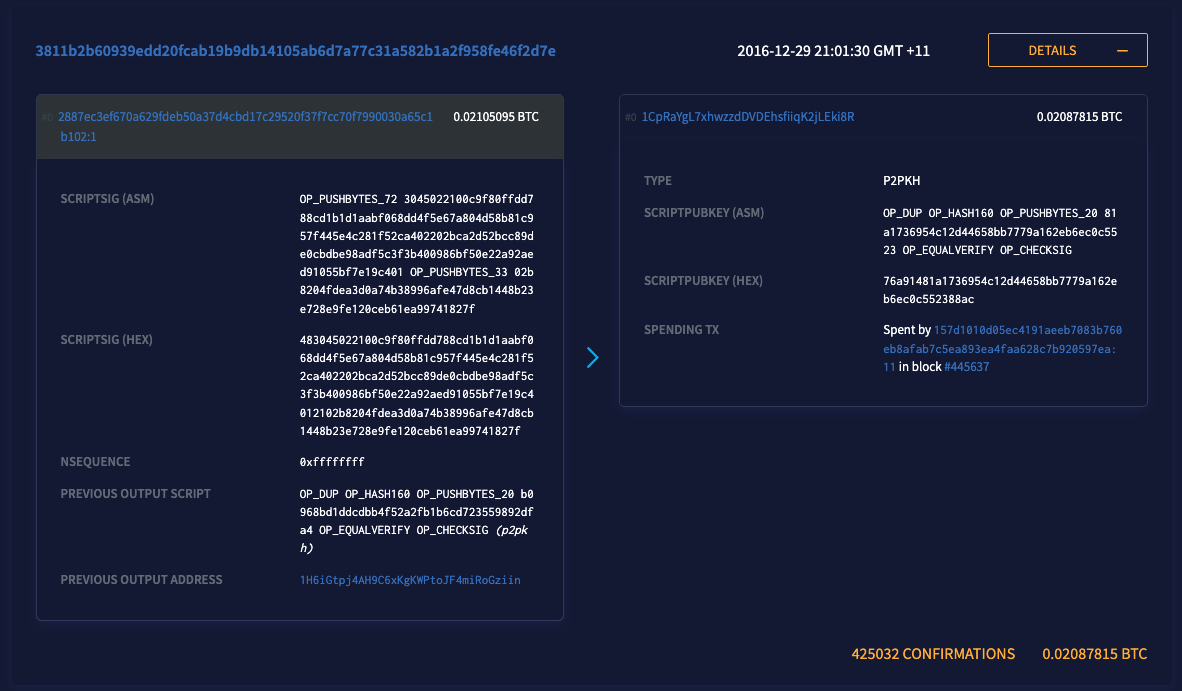

In [12]:
df_addraddr[df_addraddr['input_address']=='1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin']

input_address                      output_address
741050  1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin  1CpRaYgL7xhwzzdDVDEhsfiiqK2jLEki8R

In [13]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin']

input_address       txId
263829  1H6iGtpj4AH9C6xKgKWPtoJF4miRoGziin  139232043

In [14]:
df_txn_features[df_txn_features['txId']==139232043]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
134009  139232043         28         0.0000          1.0000     0.0209 0.0002   

           size  num_input_addresses  num_output_addresses  in_BTC_min  \
134009 192.0000               1.0000                1.0000      0.0211   

        in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
134009      0.0211       0.0211         0.0211        0.0211       0.0209   

        out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
134009       0.0209        0.0209          0.0209         0.0209

-----------------------

Illicit Address Validation #2: 1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------

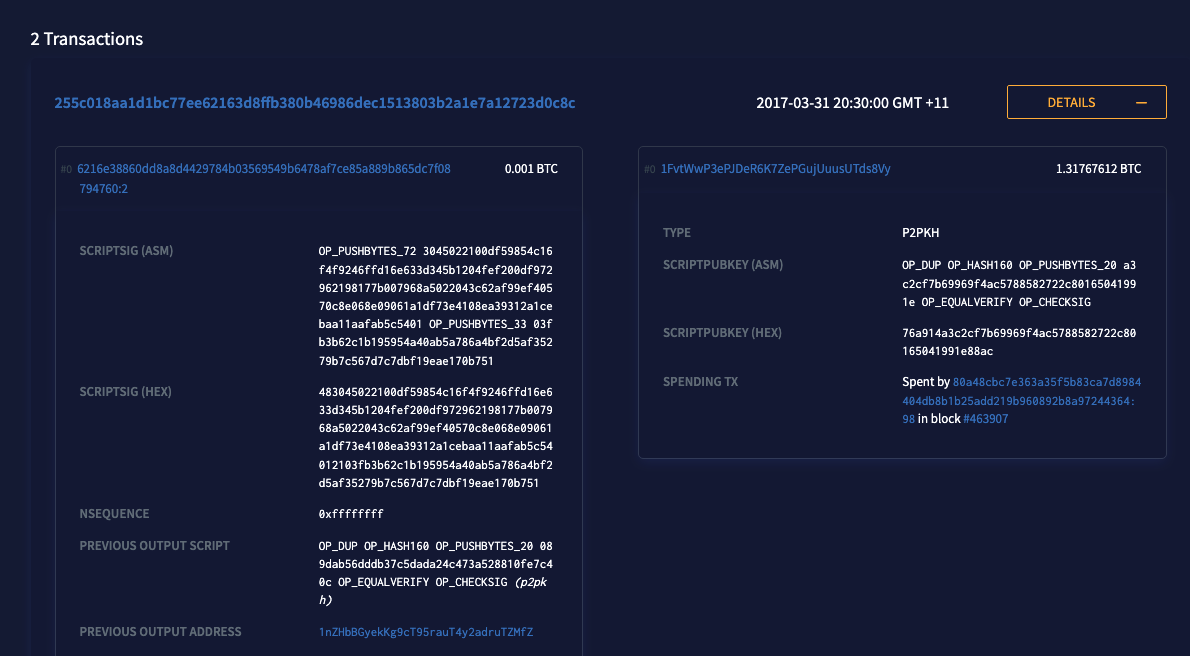

In [15]:
df_addraddr[df_addraddr['input_address']=='1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz']

input_address  \
1099202  1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz   

                             output_address  
1099202  1FvtWwP3ePJDeR6K7ZePGujUuusUTds8Vy

In [16]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz']

input_address      txId
320236  1DzPbE2QET1WmdiFywGyxzSNWWBC7jAuSz  70023047

In [17]:
df_txn_features[df_txn_features['txId']==70023047]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
126109  70023047         35        48.0000          0.0000     1.3177 0.0388   

             size  num_input_addresses  num_output_addresses  in_BTC_min  \
126109 27483.0000             186.0000                1.0000      0.0008   

        in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
126109      0.1423       0.0073         0.0029        1.3565       1.3177   

        out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
126109       1.3177        1.3177          1.3177         1.3177

-----------------------

Illicit Address Validation #3: 1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


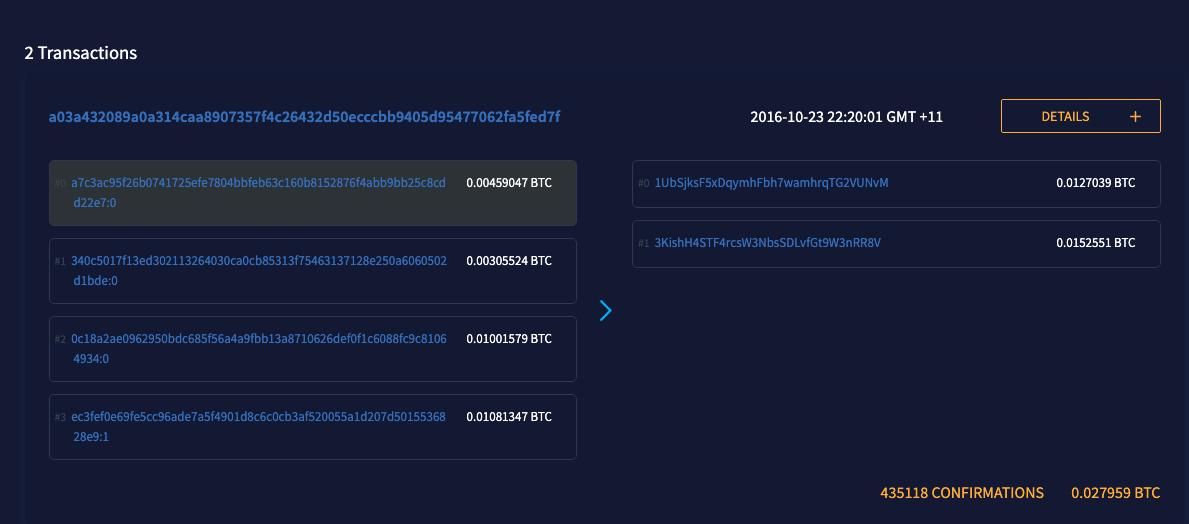

In [18]:
df_addraddr[df_addraddr['input_address']=='1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ']

input_address  \
1506327  1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ   
2797004  1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ   

                             output_address  
1506327   1UbSjksF5xDqymhFbh7wamhrqTG2VUNvM  
2797004  3KishH4STF4rcsW3NbsSDLvfGt9W3nRR8V

In [19]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ']

input_address       txId
232045  1EsMBSwcw94uCmph4bTshs6o8THZQn3QFZ  331501576

In [20]:
df_txn_features[df_txn_features['txId']==331501576]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
109178  331501576         23         0.0000          1.0000     0.0280 0.0005   

           size  num_input_addresses  num_output_addresses  in_BTC_min  \
109178 666.0000               4.0000                2.0000      0.0031   

        in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
109178      0.0108       0.0071         0.0073        0.0285       0.0127   

        out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
109178       0.0153        0.0140          0.0140         0.0280

-----------------------

Illicit Address Validation #4: 1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


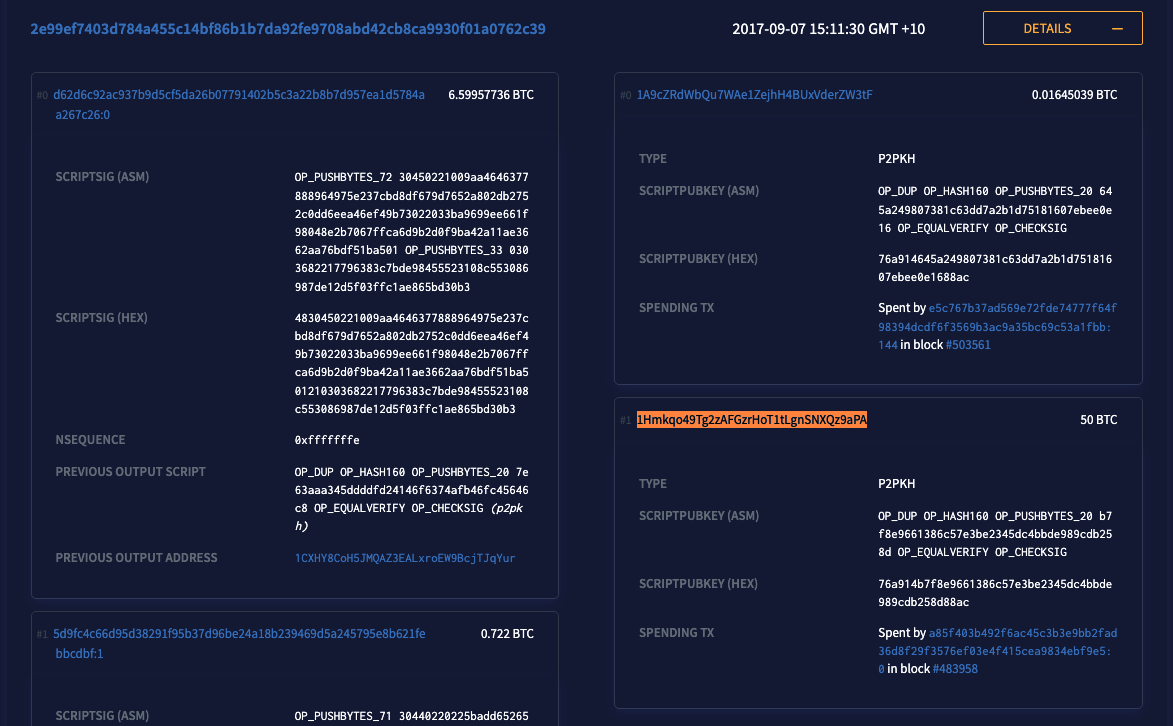

In [21]:
df_addraddr[df_addraddr['input_address']=='1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK']

input_address                      output_address
610347  1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK  1A9cZRdWbQu7WAe1ZejhH4BUxVderZW3tF
912545  1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK  1Hmkqo49Tg2zAFGzrHoT1tLgnSNXQz9aPA

In [22]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK']

input_address       txId
461192  1CXu6V1gdEqQcd3A6E1aLDqrdzJUSZTVwK  212722108

In [23]:
df_txn_features[df_txn_features['txId']==	212722108]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
124006  212722108         47         8.0000          0.0000    50.0165 0.0076   

            size  num_input_addresses  num_output_addresses  in_BTC_min  \
124006 3766.0000              25.0000                2.0000      0.0000   

        in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
124006      6.5996       2.0010         1.8360       50.0240       0.0165   

        out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
124006      50.0000       25.0082         25.0082        50.0165

-----------------------

Illicit Address Validation #5: 1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


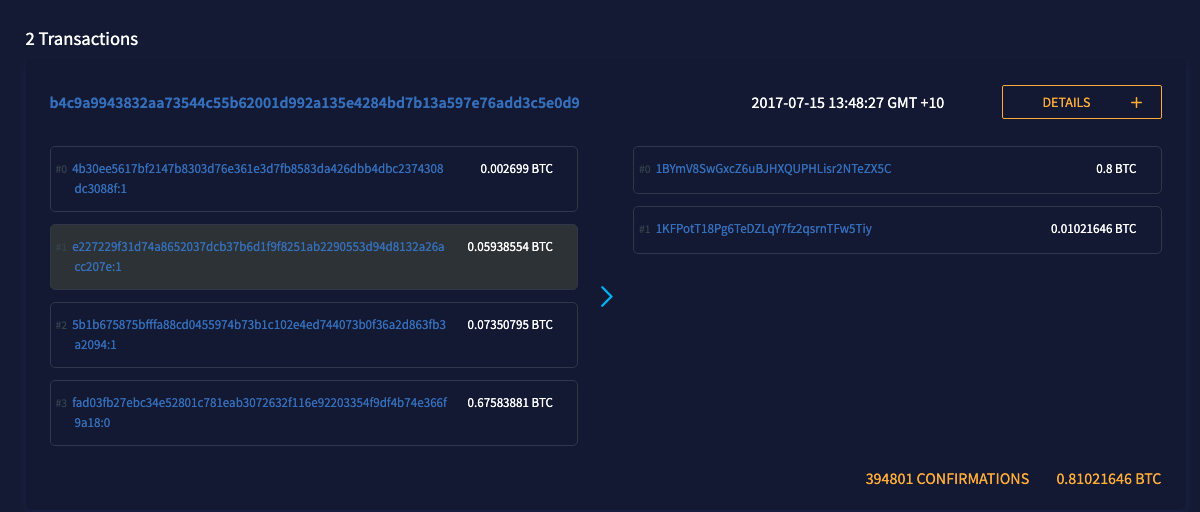

In [24]:
df_addraddr[df_addraddr['input_address']=='1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V']

input_address  \
414890   1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V   
1898937  1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V   

                             output_address  
414890   1BYmV8SwGxcZ6uBJHXQUPHLisr2NTeZX5C  
1898937  1KFPotT18Pg6TeDZLqY7fz2qsrnTFw5Tiy

In [25]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V']

input_address      txId
405925  1H2oqGARVmLUE76reV4ZdPnaVR1MHTyc6V  94151590

In [26]:
df_txn_features[df_txn_features['txId']==	94151590]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
110141  94151590         43         0.0000          1.0000     0.8102 0.0012   

           size  num_input_addresses  num_output_addresses  in_BTC_min  \
110141 668.0000               4.0000                2.0000      0.0027   

        in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
110141      0.6758       0.2029         0.0664        0.8114       0.0102   

        out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
110141       0.8000        0.4051          0.4051         0.8102

-----------------------

Illicit Address Validation #6: 1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


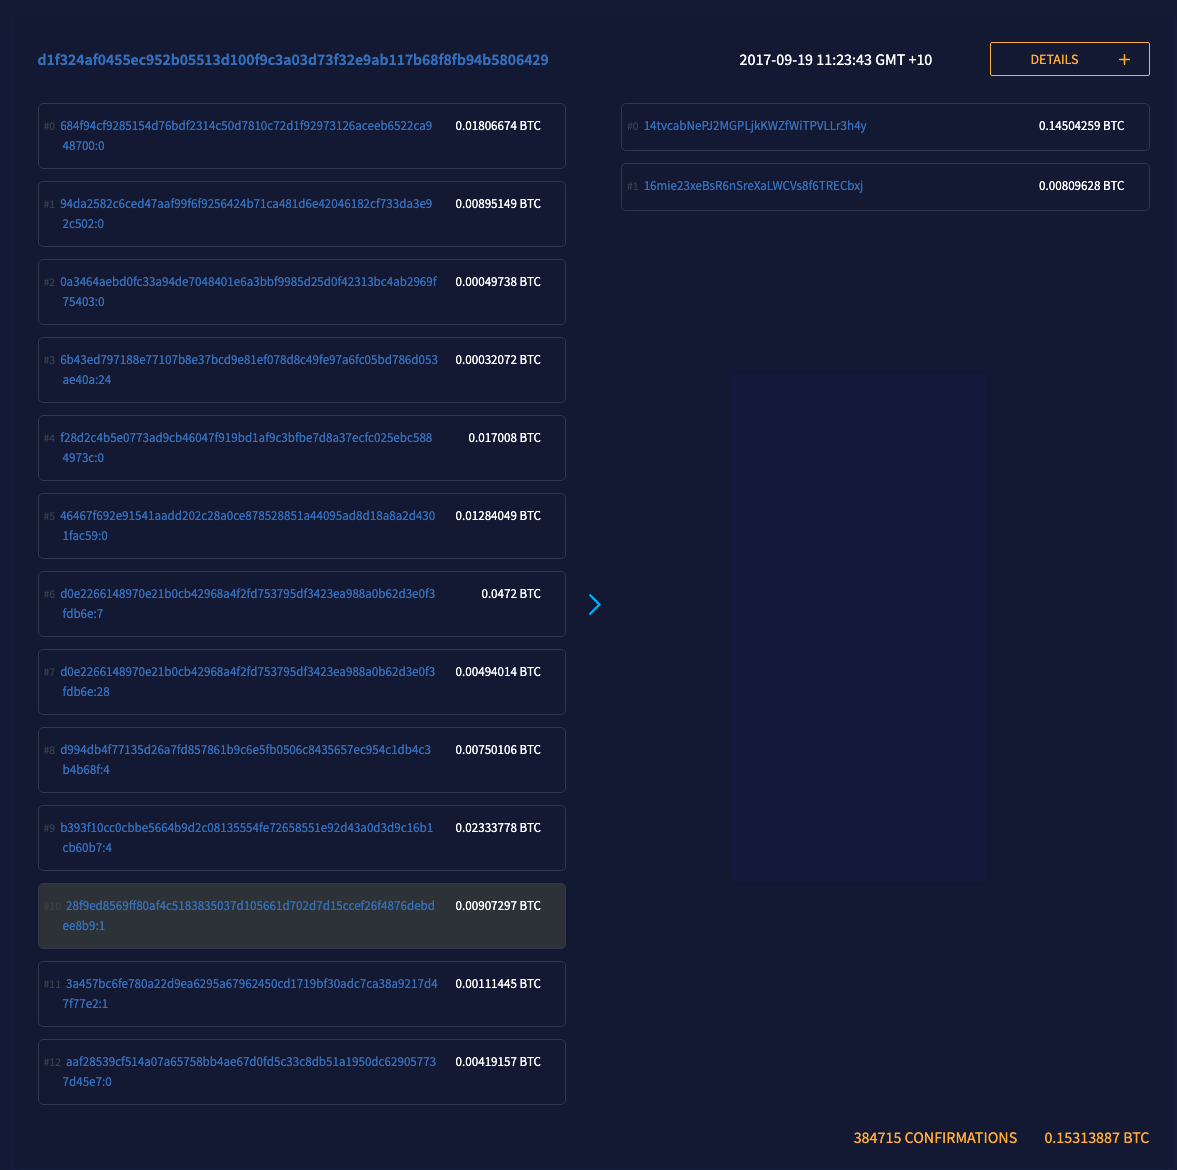

In [27]:
df_addraddr[df_addraddr['input_address']=='1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL']

input_address  \
2477820  1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL   
2514895  1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL   

                             output_address  
2477820  14tvcabNePJ2MGPLjkKWZfWiTPVLLr3h4y  
2514895  16mie23xeBsR6nSreXaLWCVs8f6TRECbxj

In [28]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL']

input_address      txId
468999  1D1SLGb19PASxR3dCY7qXLVFnsDsnJu4GL  19501341

In [29]:
df_txn_features[df_txn_features['txId']==	19501341]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
121263  19501341         48         0.0000          1.0000     0.1531 0.0019   

            size  num_input_addresses  num_output_addresses  in_BTC_min  \
121263 1994.0000              13.0000                2.0000      0.0003   

        in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
121263      0.0472       0.0119         0.0090        0.1550       0.0081   

        out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
121263       0.1450        0.0766          0.0766         0.1531

-----------------------

Illicit Address Validation #7: 1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


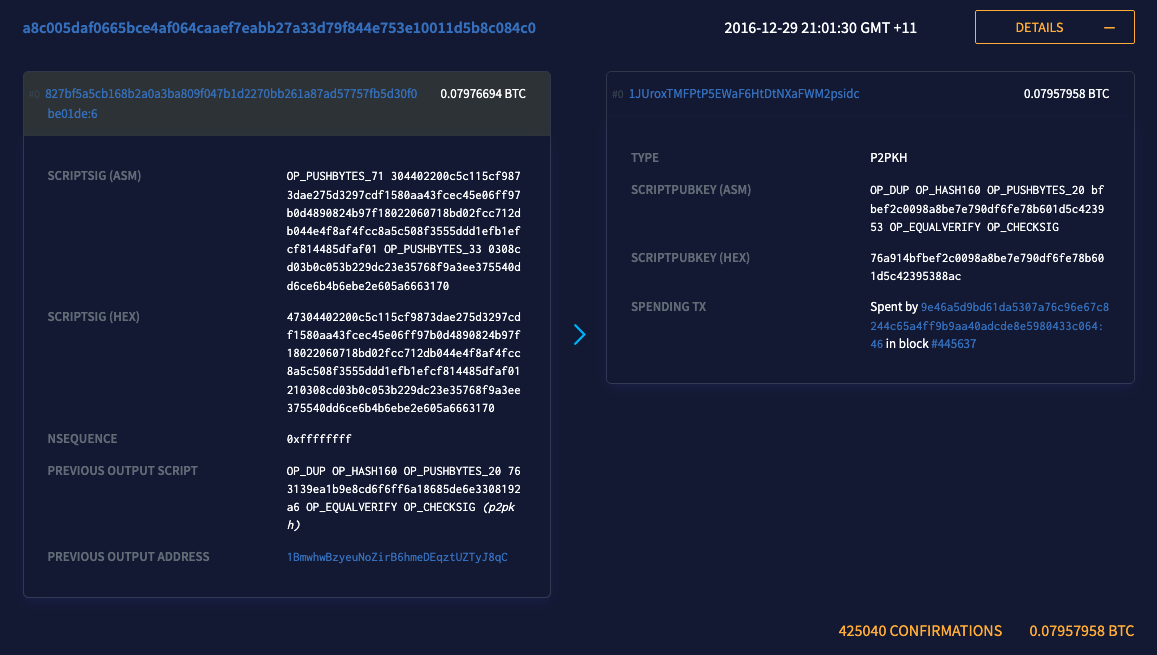

In [30]:
df_addraddr[df_addraddr['input_address']=='1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC']

input_address                      output_address
708215  1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC  1JUroxTMFPtP5EWaF6HtDtNXaFWM2psidc

In [31]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC']

input_address       txId
263764  1BmwhwBzyeuNoZirB6hmeDEqztUZTyJ8qC  139274519

In [32]:
df_txn_features[df_txn_features['txId']==	139274519]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
1663  139274519         28         0.0000          1.0000     0.0796 0.0002   

         size  num_input_addresses  num_output_addresses  in_BTC_min  \
1663 191.0000               1.0000                1.0000      0.0798   

      in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
1663      0.0798       0.0798         0.0798        0.0798       0.0796   

      out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
1663       0.0796        0.0796          0.0796         0.0796

-----------------------

Illicit Address Validation #8: 1GxNcfosQouiwjtui1kALEN61zR5DqXNhS

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1GxNcfosQouiwjtui1kALEN61zR5DqXNhS
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


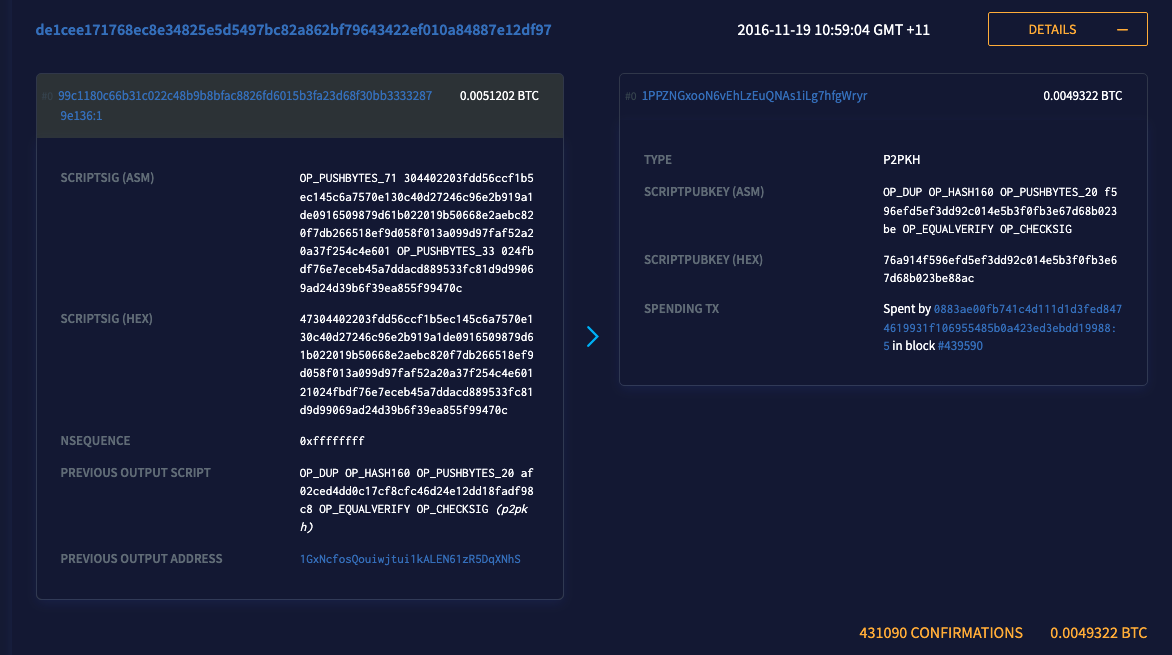

In [33]:
df_addraddr[df_addraddr['input_address']=='1GxNcfosQouiwjtui1kALEN61zR5DqXNhS']

input_address  \
2844377  1GxNcfosQouiwjtui1kALEN61zR5DqXNhS   

                             output_address  
2844377  1PPZNGxooN6vEhLzEuQNAs1iLg7hfgWryr

In [34]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1GxNcfosQouiwjtui1kALEN61zR5DqXNhS']

input_address       txId
248183  1GxNcfosQouiwjtui1kALEN61zR5DqXNhS  268791658

In [35]:
df_txn_features[df_txn_features['txId']==		268791658]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
1332  268791658         25         0.0000          1.0000     0.0049 0.0002   

         size  num_input_addresses  num_output_addresses  in_BTC_min  \
1332 191.0000               1.0000                1.0000      0.0051   

      in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
1332      0.0051       0.0051         0.0051        0.0051       0.0049   

      out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
1332       0.0049        0.0049          0.0049         0.0049

-----------------------

Illicit Address Validation #9: 1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


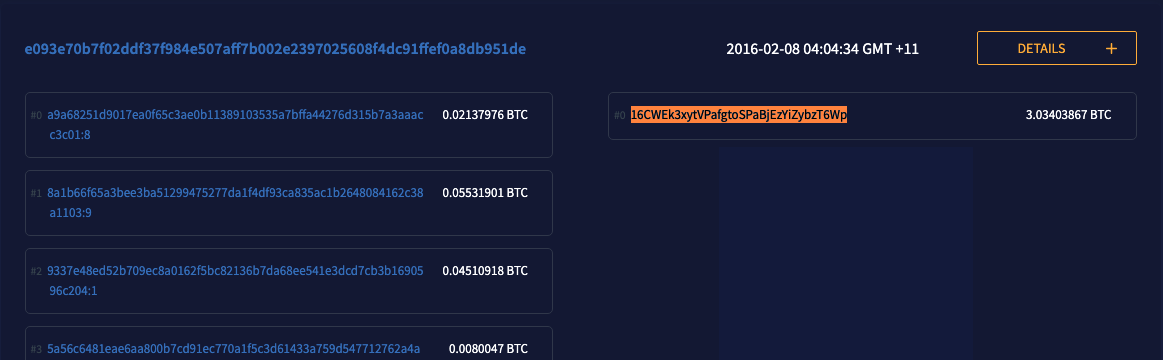

In [36]:
df_addraddr[df_addraddr['input_address']=='1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx']

input_address  \
1387602  1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx   

                             output_address  
1387602  16CWEk3xytVPafgtoSPaBjEzYiZybzT6Wp

In [37]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx']

input_address       txId
46492  1Ea6fUL4SetTurKScVjPrrtQkY6bXoSjEx  279470784

In [38]:
df_txn_features[df_txn_features['txId']==279470784]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
125674  279470784          4         0.0000          1.0000     3.0340 0.0034   

             size  num_input_addresses  num_output_addresses  in_BTC_min  \
125674 14792.0000             100.0000                1.0000      0.0013   

        in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
125674      0.4884       0.0304         0.0226        3.0375       3.0340   

        out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
125674       3.0340        3.0340          3.0340         3.0340

-----------------------

Illicit Address Validation #10: 17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN

Notes:
- Input address, output address and BTC txn value are validated using BTC Scan https://btcscan.org/address/17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN
- This is the same transaction as Example #9. This input address is one of 100 input addresses in the same transaction.
- No illicit reports on https://www.chainabuse.com/
- No illicit reports on https://tools.cybertrace.com.au/

-----------------------


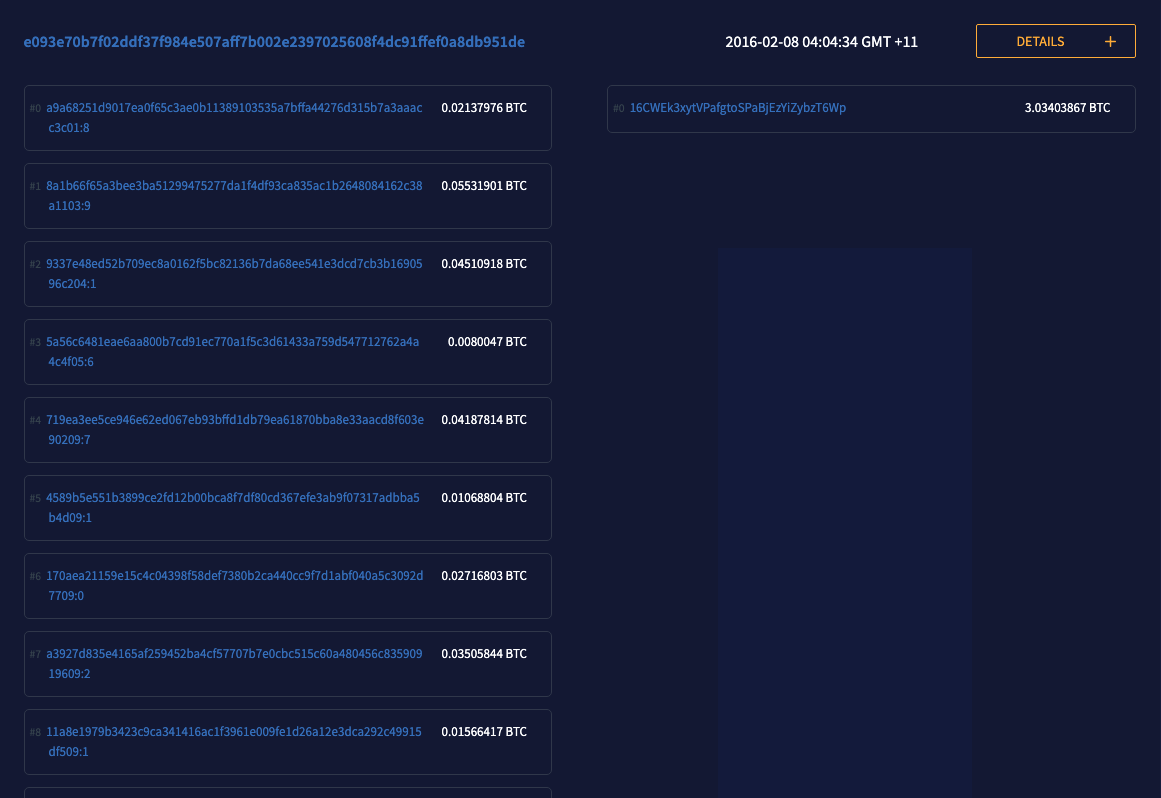

In [39]:
df_addraddr[df_addraddr['input_address']=='17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN']

input_address                      output_address
1350196  17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN  16CWEk3xytVPafgtoSPaBjEzYiZybzT6Wp

In [40]:
df_addrtxn_edgelist[df_addrtxn_edgelist['input_address']=='17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN']

input_address       txId
46483  17mvMgJUms7xp51ch6B2N6WbfwFkJH6FN  279470784

In [41]:
df_txn_features[df_txn_features['txId']==279470784]

txId  Time step  in_txs_degree  out_txs_degree  total_BTC   fees  \
125674  279470784          4         0.0000          1.0000     3.0340 0.0034   

             size  num_input_addresses  num_output_addresses  in_BTC_min  \
125674 14792.0000             100.0000                1.0000      0.0013   

        in_BTC_max  in_BTC_mean  in_BTC_median  in_BTC_total  out_BTC_min  \
125674      0.4884       0.0304         0.0226        3.0375       3.0340   

        out_BTC_max  out_BTC_mean  out_BTC_median  out_BTC_total  
125674       3.0340        3.0340          3.0340         3.0340

----------------------

Illicit Samples where the volume of transactions is high.

The reason for selecting addresses with high transaction volume is so we can validate whether the address is licit or illicit using public address lookup / AML websites.

Note:
- Using free wallet address lookups (chainabuse.com and cybertrace.com.au) there have been no illicit activity noted.
- There are many other AML crypto wallet lookup serves (e.g. Elliptic) but they are paid services.

----------------------

In [42]:
illicit_address = df_wallet_combined_clean[(df_wallet_combined_clean['class_label']=='Illicit')].sort_values(ascending = False, by = 'total_txs').head(10)
illicit_address

address  class class_label  \
568610  39sfuA8pY4UfybgEZi7uvA13jkGzZpsg5K      1     Illicit   
381467  1DYyueWpZriK9mdCKqUPiTKg3vaHYaPdCK      1     Illicit   
576353  13PTX5TUaGvPPZ5j1ushpDzeFqwVCzkwXg      1     Illicit   
522347  1GQSnzh9JRgipxC7btKvD3rBS8Zj8SVnAo      1     Illicit   
555926  1HF1yyeF8TNRnUuSES94KduL1pXg2wKmT8      1     Illicit   
387808  1H9xYMZv9Ya3SU58in3PnydtnJm8cPHRi9      1     Illicit   
327475  12Vm7yZwr45D2ZTiA2w3eY5RTxTP1WNYpw      1     Illicit   
550178  1JUroxTMFPtP5EWaF6HtDtNXaFWM2psidc      1     Illicit   
576352  1F4pFZe1y386fQSfw8y2W2rgHFjaLq8qkg      1     Illicit   
420322  1Ehij6LRagCoX4F1WYd5PxQ15gz1bQfYTb      1     Illicit   

        num_txs_as_sender  num_txs_as receiver  first_block_appeared_in  \
568610           420.0000               1.0000              435559.0000   
381467             5.0000              89.0000              415393.0000   
576353             1.0000              92.0000              453697.0000   
522347            35.0000              33.0000              437582.0000   
555926             1.0000              64.0000              447651.0000   
387808             1.0000              63.0000              415396.0000   
327475             2.0000              60.0000              407338.0000   
550178             1.0000              59.0000              445634.0000   
576352             1.0000              58.0000              453697.0000   
420322             1.0000              58.0000              423464.0000   

        last_block_appeared_in  lifetime_in_blocks  total_txs  \
568610             453704.0000          18145.0000   421.0000   
381467             415397.0000              4.0000    94.0000   
576353             453705.0000              8.0000    93.0000   
522347             477896.0000          40314.0000    68.0000   
555926             447652.0000              1.0000    65.0000   
387808             415397.0000              1.0000    64.0000   
327475             407340.0000              2.0000    62.0000   
550178             445637.0000              3.0000    60.0000   
576352             453702.0000              5.0000    59.0000   
420322             423467.0000              3.0000    59.0000   

        first_sent_block  first_received_block  num_timesteps_appeared_in  \
568610       435559.0000           451682.0000                     6.0000   
381467       415395.0000           415393.0000                     1.0000   
576353       453705.0000           453697.0000                     1.0000   
522347       453703.0000           437582.0000                    15.0000   
555926       447652.0000           447651.0000                     1.0000   
387808       415397.0000           415396.0000                     1.0000   
327475       407340.0000           407338.0000                     1.0000   
550178       445637.0000           445634.0000                     1.0000   
576352       453702.0000           453697.0000                     1.0000   
420322       423467.0000           423464.0000                     1.0000   

        btc_transacted_total  btc_transacted_min  btc_transacted_max  \
568610               27.4758              0.0006             20.0000   
381467               55.9634              0.0015             16.2218   
576353               26.9458              0.0007             13.4729   
522347                9.7612              0.0005              1.9995   
555926               24.5406              0.0026             12.2703   
387808               39.9718              0.0075             19.9859   
327475               47.9205              0.0115             18.1116   
550178               39.6205              0.0049             19.8102   
576352               17.9637              0.0028              8.9818   
420322               24.4723              0.0034              5.9794   

        btc_transacted_mean  btc_transacted_median  btc_sent_total  \
568610               0.0653                 0.0041          7.4758

End of Validation